In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.9/184.9 MB 4.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 4.1 MB/s eta 0:00:0000:0100:01


In [3]:
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.scorer import Scorer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm
from torch.optim import AdamW
import pickle
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter


2023-12-09 13:53:40.498762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 13:53:41.935437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 13:53:41.935487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 13:53:41.971352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 13:53:42.740214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 13:53:42.747112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
def process_text(text):
    ''' Process the text: lowercasing, lemmatization, stopwords removal, 
        and punctuation removal
        Input: text: the text to be processed'''
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('  ', ' ')

    # Word tokenization 
    tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

In [5]:
def plot_classes_distribution(labels, num_samples_per_class):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.barh(labels, num_samples_per_class)
    plt.xlabel("Number of samples")
    plt.ylabel("Class")
    plt.title("Distribution of the classes")
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

In [6]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4966 [00:00<?, ? examples/s]

as a recap from exericse one, let's have a look again at the classes

In [7]:
# Calculate basic statistics
# Number of samples, number of classes, number of samples per class
# Number of samples
num_samples = len(dataset['train'])
print("Number of samples: ", num_samples)

# Number of classes
labels = []
for sample in dataset['train']['prediction']:
    label = sample[0]['label']
    if label not in labels:
        labels.append(label)

num_classes = len(labels)
print("Number of classes: ", num_classes)

Number of samples:  4966
Number of classes:  40


In [8]:
# Number of samples per class
num_samples_per_class = []
for label in labels:
    num_samples_per_class.append(len(dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label)))

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

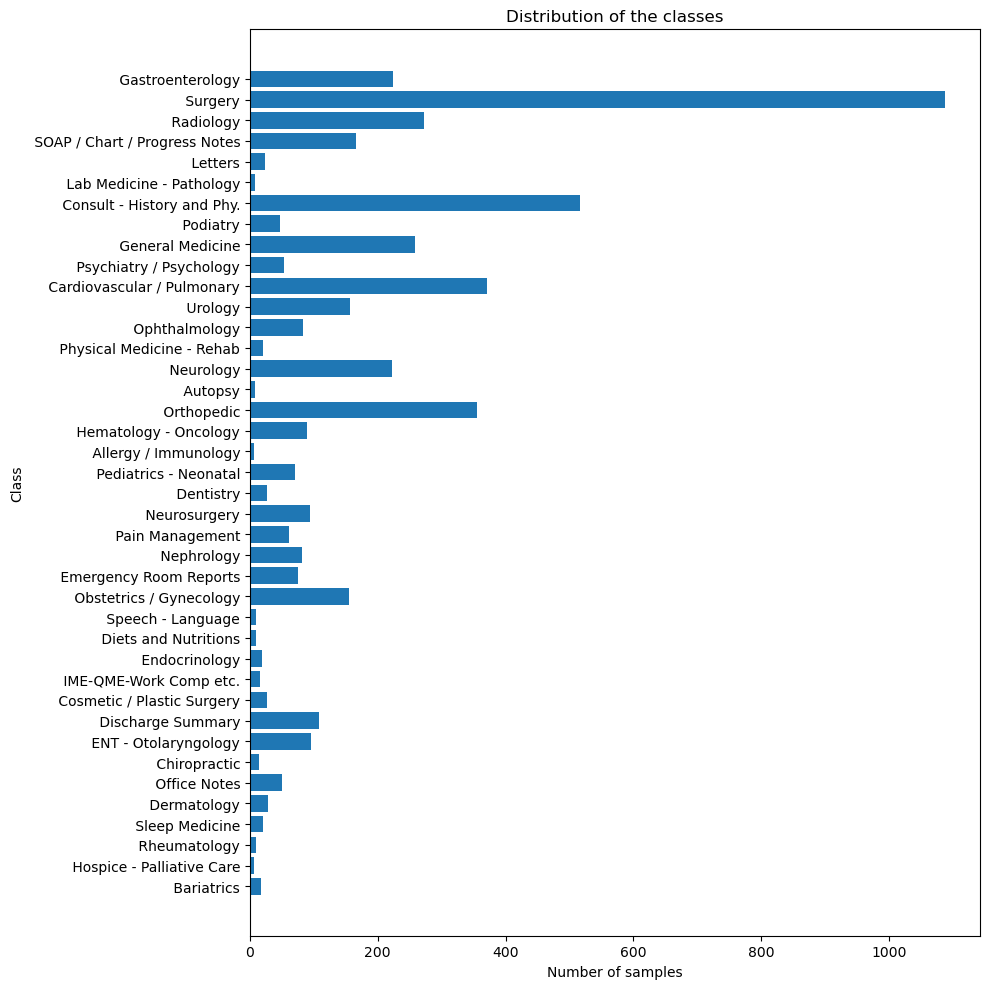

In [9]:
# plot the distribution of the classes
plot_classes_distribution(labels, num_samples_per_class)

Next we are going to set the environment that we created in Task 1 for the preprocessing of the text using the pipeline provided in our Task 1 notebook. 

In [10]:
# preprocess the data
dataset_p = pd.DataFrame(columns=['tokens', 'label'])
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text']
    label = dataset['train'][i]['prediction'][0]['label']
    text_p = process_text(text)
    dataset_p.loc[i] = [text_p, label]

In [11]:
dataset_p.head()

,tokens,label
0,preoperative diagnosis iron deficiency postope...,Gastroenterology
1,clinical indication normal stress procedure pe...,Surgery
2,finding scan performed reformatted image obtai...,Radiology
3,preoperative diagnosis blood loss postoperativ...,Surgery
4,reason visit elevated psa nocturia occasional ...,SOAP / Chart / Progress Notes


In [12]:
#how many labels are there
print(len(dataset_p['label'].unique()))
dataset_p['label'].value_counts().sort_index()

40


label
 Allergy / Immunology                7
 Autopsy                             8
 Bariatrics                         18
 Cardiovascular / Pulmonary        371
 Chiropractic                       14
 Consult - History and Phy.        516
 Cosmetic / Plastic Surgery         27
 Dentistry                          27
 Dermatology                        29
 Diets and Nutritions               10
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Emergency Room Reports             75
 Endocrinology                      19
 Gastroenterology                  224
 General Medicine                  259
 Hematology - Oncology              90
 Hospice - Palliative Care           6
 IME-QME-Work Comp etc.             16
 Lab Medicine - Pathology            8
 Letters                            23
 Nephrology                         81
 Neurology                         223
 Neurosurgery                       94
 Obstetrics / Gynecology           155
 Office Notes      

In [13]:
#convert labels to numbers
label2idx = {}
idx2label = {}
for i, label in enumerate(dataset_p['label'].unique()):
    label2idx[label] = i
    idx2label[i] = label

dataset_p['label'] = dataset_p['label'].map(label2idx)
dataset_p.head()


,tokens,label
0,preoperative diagnosis iron deficiency postope...,0
1,clinical indication normal stress procedure pe...,1
2,finding scan performed reformatted image obtai...,2
3,preoperative diagnosis blood loss postoperativ...,1
4,reason visit elevated psa nocturia occasional ...,3


In [14]:
#wnat to use clinicalBERT for classification -> use its tokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
## playing around with the tokenization
# apply tokenize on a sample and check the output
sample = dataset_p["tokens"][0]

print("Sample text before tokenization: ", sample)
# apply tokenization directly on the sample
# sample = tokenize(sample)
tokens = process_text(sample)
print(tokens)
sample = tokenizer.encode(sample)
print("Sample text after tokenization: ", tokenizer.convert_ids_to_tokens(sample))

Sample text before tokenization:  preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation wa good although wa residual material cecum wa difficult clear completely mucosa wa normal throughout colon polyp lesion identified blood wa noted diverticulum seen sigmoid colon luminal narrowing evidence inflammation retroflex view anorectal junction showed hemorrhoid patient tolerated procedure well wa sent recovery final diagnosis diverticulosis otherwise normal colonoscopy recommendation follow x screening colonoscopy additional evaluation cause anemia may appropriate
preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation 

In [16]:
# get max length of the tokens

idx = dataset_p["tokens"].apply(len).idxmax()

# Get that row
len(dataset_p.iloc[idx]["tokens"])

12039

In [17]:
# Function to return the length of tokenized text
#use BERT tokens or normal tokens?
def count_tokens_bert(text):
    return len(tokenizer.encode(text))


def count_tokens(text):
    return len(text.split())


# Apply the function to each row and find the maximum length
token_lengths = dataset_p["tokens"].apply(count_tokens)
max_token_length = max(token_lengths)

print("Maximum number of tokens in a single row:", max_token_length)

Maximum number of tokens in a single row: 1636


the max nb of tokens that BERT can take is 512, so this entry will be truncated to 512 tokens

In [18]:

token_lengths = dataset_p["tokens"].apply(count_tokens)

In [19]:
# how many tokens have lenght > 512
token_lengths[token_lengths > 512].count() / len(token_lengths)

0.09021345146999597

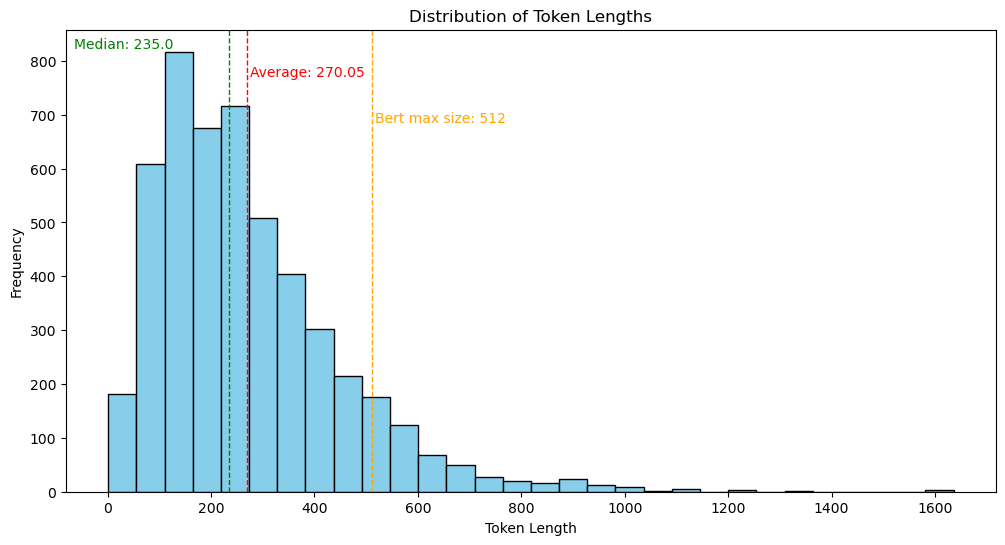

In [20]:
average_token_length = token_lengths.mean()
median_token_length = token_lengths.median()
bert_max_size = 512

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(average_token_length, color="red", linestyle="dashed", linewidth=1)
plt.axvline(median_token_length, color="green", linestyle="dashed", linewidth=1)
plt.axvline(bert_max_size, color="orange", linestyle="dashed", linewidth=1)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.text(
    average_token_length + 5,
    plt.ylim()[1] * 0.9,
    f"Average: {average_token_length:.2f}",
    color="red",
)
plt.text(
    median_token_length - 300,
    plt.ylim()[1] * 0.96,
    f"Median: {median_token_length}",
    color="green",
)
plt.text(
    bert_max_size + 5,
    plt.ylim()[1] * 0.8,
    f"Bert max size: {bert_max_size}",
    color="orange",
)

plt.show()

In [21]:
# split rows that have more than 512 tokens into multiple rows to not lose data
def split_text(text, max_length):
    # Tokenize the text into words (not BERT tokens)
    words = text.split()

    # Split words into chunks of max_length
    chunks = [
        " ".join(words[i : i + max_length]) for i in range(0, len(words), max_length)
    ]
    return chunks

In [22]:
max_length = 512 - 2  # accounting for [CLS] and [SEP]

new_rows = []
for _, row in dataset_p.iterrows():
    text_chunks = split_text(row["tokens"], max_length)
    for chunk in text_chunks:
        new_rows.append({"tokens": chunk, "label": row["label"]})

# Create a new DataFrame
split_dataset_p = pd.DataFrame(new_rows)

In [23]:
token_lengths = split_dataset_p["tokens"].apply(count_tokens)


In [24]:
max_token_length = max(token_lengths)
print("Maximum number of tokens in a single row:", max_token_length)

Maximum number of tokens in a single row: 510


the average length is 428 tokens and the median is 369, so truncating to 512 should be fine. however, in this case 30% of the entries will be truncated

In [25]:
def tokenize(sent):
    encoded = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
    )
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
    }

In [29]:
torch.tensor(split_dataset_p["label"].values)

tensor([ 0,  1,  2,  ...,  1, 16,  1])

In [31]:
train_df, eval_df = train_test_split(split_dataset_p, test_size=0.2, stratify=torch.tensor(split_dataset_p["label"].values))

train_encodings = train_df["tokens"].apply(lambda x: tokenize(x))
eval_encodings = eval_df["tokens"].apply(lambda x: tokenize(x))

train_labels = torch.tensor(train_df["label"].values)
eval_labels = torch.tensor(eval_df["label"].values)

train_inputs = torch.cat(
    train_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0
)
train_masks = torch.cat(
    train_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

eval_inputs = torch.cat(eval_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0)
eval_masks = torch.cat(
    eval_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

In [ ]:
#get a weight per sample based on the label: label_weight = 1/ (num_classes * num_samples_per_class[class_label])   
weight_samples=1/(torch.index_select(torch.tensor(num_samples_per_class),0,train_labels)*num_classes)

In [ ]:
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
eval_dataset = TensorDataset(eval_inputs, eval_masks, eval_labels)

#train_sampler = RandomSampler(train_dataset)
train_sampler = WeightedRandomSampler(weight_samples, num_samples=train_labels.shape[0], replacement=False)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")	

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "medicalai/ClinicalBERT",
    num_labels=40,
)
model.to(device)

In [ ]:
def evaluate(model, dataloader):
    model.eval()

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = batch_labels.to("cpu").numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average="macro"
    )

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
num_epochs = 100
max_patience=5
patience = max_patience
best_f1 = 0
optimizer = AdamW(model.parameters(), lr=5e-5)
it = 0
# Create tensorboard
summary = SummaryWriter("./", purge_step=0)

epoch_length = len(train_dataloader)

from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")
    model.train()

    for batch in tqdm(train_dataloader):
        it += 1
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        if (it % (epoch_length/8)) == 0:
            summary.add_scalar("training loss", loss.cpu().item(), it)  
    
    eval_metrics = evaluate(model, eval_dataloader)
    for key in eval_metrics:
        summary.add_scalar(key, eval_metrics[key], epoch +1)
        
    f1 = eval_metrics['f1']            
    
    if best_f1 < f1:
        patience = max_patience
        best_f1=f1
        torch.save(model.state_dict(), "best_model.pt")

    else:
        patience -= 1
    
    print(f"My remaining patience is {patience}.") 
    if patience <= 0:
        print("My patience run out.") 
        break
        
print("Training finished with " + str(num_epochs) + " epochs")  
            

In [ ]:
model = torch.load("best_model.pt")
eval_metrics = evaluate(model, eval_dataloader)
print(
    f"Validation Results - Accuracy: {eval_metrics['accuracy']:.3f}, Precision: {eval_metrics['precision']:.3f}, Recall: {eval_metrics['recall']:.3f}, F1: {eval_metrics['f1']:.3f}"
)

copied from ubelix:

#### with preprocessing:

Validation Results - Accuracy: 0.336, Precision: 0.295, Recall: 0.336, F1: 0.303

#### without preprocessing (tokenization only):

Validation Results - Accuracy: 0.311, Precision: 0.266, Recall: 0.311, F1: 0.279

#### with preprocessing and splitting rows > 512 tokens:
Validation Results - Accuracy: 0.338, Precision: 0.290, Recall: 0.338, F1: 0.275

In [ ]:
# load predictions and true labels and plot
with open("model_evaluation_data_project.pkl", "rb") as handle:
    dict_pp = pickle.load(handle)

y_test_pp = dict_pp["true_labels"]
preds_pp = dict_pp["predictions"]
print(dict_pp.keys())

In [ ]:
with open("model_evaluation_data_project_tokenizer_only.pkl", "rb") as handle:
    dict_nopp = pickle.load(handle)

##compare to model without preprocessing
y_test_nopp = dict_nopp["true_labels"]
preds_nopp = dict_nopp["predictions"]



In [ ]:
with open("model_evaluation_data_project_split_rows.pkl", "rb") as handle:
    dict_split = pickle.load(handle)

##compare to model without preprocessing
y_test_split = dict_split["true_labels"]
preds_split = dict_split["predictions"]

In [ ]:
labels= dataset_p['label'].unique().tolist()
labels

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_pp, preds_pp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Normalized Confusion Matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
cm = confusion_matrix(y_test_nopp, preds_nopp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix without preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split, preds_split)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing and splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

confusion matrix without the splitting looks better to me. here it seems that the model learnt that there are many surgery cases and no mostly predicts surgery, independent of the actual label.


TODO: how to deal with class imbalance?